In [1]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
import cv2
import os
import time
import datetime
import math
from typing import Optional, Callable
from collections import defaultdict, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms as T
from torchvision.transforms import functional as F
from torchvision.models import resnet18
from torchvision.ops import box_area
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)

In [3]:
class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))

In [4]:
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

In [5]:
def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

In [6]:
def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

In [7]:
def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

In [8]:
def show_img_with_bb(img, bb, width=5):
    """Draw image with bounding boxes"""

    PIL_to_tensor = T.PILToTensor()
    Tensor_to_PIL = T.ToPILImage()
    img = PIL_to_tensor(img)
    img = draw_bounding_boxes(img, bb, colors='red', width=width)
    img = Tensor_to_PIL(img)
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img)
    

In [9]:
def Resize_img_bb(img, bb, size):
    """Resize image and bounding boxes"""
    if len(bb) == 0:
        return img, bb
    
    resized_bb = []
    PIL_to_tensor = T.PILToTensor()
    Tensor_to_PIL = T.ToPILImage()
    Resize = T.Resize(size)
    
    for box in bb:
        temp_b = []
        temp_b.append(box[0]*size[0]/img.size[0])
        temp_b.append(box[1]*size[1]/img.size[1])
        temp_b.append(box[2]*size[0]/img.size[0])
        temp_b.append(box[3]*size[1]/img.size[1])
        resized_bb.append(temp_b)
    resized_bb = torch.as_tensor(resized_bb)
    img = PIL_to_tensor(img)
    img = Resize(img)
    img = Tensor_to_PIL(img)
    
    return img, resized_bb

# Roots to datasets (for 198-classes and 6-classes)

In [11]:
root_classification_image = "C:/Users/yuras/Projects/Signs/data/classification/rtsd-r3"
root_classification_gt = "C:/Users/yuras/Projects/Signs/data/classification/rtsd-r3"
root_detection_image = "C:/Users/yuras/Projects/Signs/data/detection/rtsd-d3-frames"
root_detection_gt = "C:/Users/yuras/Projects/Signs/data/detection/rtsd-d3-gt"
root_full = "C:/Users/yuras/Projects/Signs/data/rtsd-frames/"
root_full_gt = "C:/Users/yuras/Projects/Signs/data/full-gt.csv"

In [12]:
num_to_class = pd.read_csv(root_classification_gt+'/numbers_to_classes.csv')

In [34]:
clas = num_to_class[num_to_class.class_number == 2].values[0][1]
clas

'1_11_1'

In [50]:
blue_border_gt = pd.read_csv(root_detection_gt+'/prohibitory/train_gt.csv')

In [51]:
blue_border_gt.sign_class.unique()

array(['3_24_n40', '3_24_n20', '3_4_n8', '3_4_1', '3_27', '3_18',
       '3_24_n5', '3_24_n30', '3_24_n60', '3_24_n70', '3_24_n50', '3_32',
       '2_5', '3_1', '3_20', '3_13_r4.5', '3_2', '3_24_n80', '3_10',
       '3_28', '3_24_n10', '2_6', '3_18_2', '3_19', '3_30', '3_29',
       '3_11_n5', '3_13_r3.5'], dtype=object)

In [12]:
def get_class_dict(gt_df: pd.DataFrame):
    class_dict = {}
    
    for cl, sign in enumerate(gt_df['sign_class'].unique()):
        class_dict.setdefault(sign, cl+1)
        
    return class_dict

In [13]:
def give_sings_from_dict(number: int, class_dict: dict):
    if number == 0:
        return 0
    for sign, sign_id in class_dict.items():
        if sign_id == number:
            return sign

In [14]:
full_gt = pd.read_csv(root_full_gt)

In [15]:
class_dict = get_class_dict(full_gt)

In [16]:
class RTSD_six_class(Dataset):
    """
    Image dataset structured as follows:
    root_image/
               ├── train/
               │       ├── img1.jpg
               │       ├── img2.jpg
               │       └── img3.jpg
               └── test/
                        ├── img1.jpg
                        ├── img2.jpg
                        └── img3.jpg
            
    GT's of image dataset structured as follows:
    root_gt/
        ├── class_x
        │   ├── train_gt.csv
        |   └── test_gt.csv
        └── class_y
            ├── train_gt.csv
            └── test_gt.csv
    """
    
    def __init__(
        self,
        root_image: str,
        root_gt: str,
        train: bool = True,
        transform = None
    ):
        if train:
            self.root_image = os.path.join(root_image, 'train')
            self.gt_filename = 'train_gt.csv'
        else:
            self.root_image = os.path.join(root_image, 'test')
            self.gt_filename = 'test_gt.csv'
        self.root_gt = root_gt
        self.train = train
        self.transform = transform
        self.imgs = os.listdir(self.root_image) 
          
    def __getitem__(self, idx):
        # load images
        img_path = os.path.join(self.root_image, self.imgs[idx])
        img = Image.open(img_path).convert('RGB')
        
        # get labels
        labels = [0., 0., 0., 0., 0., 0.]
        cl_num = 0
        
        # Each of 6 folders in path root_gt is a class
        for n, cl in enumerate(os.listdir(self.root_gt)):
            path = os.path.join(self.root_gt, cl)
            
            # There are also two .txt files in path root_gt, so check it
            if os.path.isdir(path):
                gt_df = pd.read_csv(os.path.join(path, self.gt_filename))
            else: continue
                
            # Count amount of signs of these class on the image
            if self.imgs[idx] in list(gt_df['filename']):
                labels[n] = 1.
        
        # Convert labels and img into a torch.Tensor   
        labels = torch.tensor([boxes])
        
        if self.transform:
            img = self.transform(img)
        
        print(f"ИТОГО ДЛЯ №{idx}:\n    img = {img}\n    labels = {labels}\n________________________________________________")
        
        return img, labels

    def __len__(self):
        return len(self.imgs)

In [17]:
class RTSD_by_groups(Dataset):
    """    
        Image dataset structured as follows:
    root_image/
               ├── train/
               │       ├── img1.jpg
               │       ├── img2.jpg
               │       └── img3.jpg
               └── test/
                        ├── img1.jpg
                        ├── img2.jpg
                        └── img3.jpg
            
    GT's of image dataset structured as follows:
    root_gt/
        ├── class_x
        │   ├── train_gt.csv
        |   └── test_gt.csv
        └── class_y
            ├── train_gt.csv
            └── test_gt.csv
    """
    
    def __init__(
        self,
        root_image: str,
        root_gt: str,
        train: bool = True,
        transform = False
    ):
        if train:
            self.root_image = os.path.join(root_image, 'train')
            img_df = pd.read_csv(os.path.join(root_gt, 'train_filenames.txt'), names=['filename'])
            self.gt_filename = 'train_gt.csv'
        else:
            self.root_image = os.path.join(root_image, 'test')
            img_df = pd.read_csv(os.path.join(root_gt, 'test_filenames.txt'), names=['filename'])
            self.gt_filename = 'test_gt.csv'
            
        self.imgs = list(img_df.filename)
        self.root_gt = root_gt
        self.train = train
        self.transform = transform
          
    def __getitem__(self, idx):
        # load images
        img_path = os.path.join(self.root_image, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        
        # get boxes and labels
        boxes = []
        labels = []
#         print(self.imgs[idx])
        
        for n, cl in enumerate(os.listdir(self.root_gt)):
            path = os.path.join(self.root_gt, cl)
        
            if os.path.isdir(path):
                gt_df = pd.read_csv(os.path.join(path, self.gt_filename))
            else: continue
            
            if self.imgs[idx] in list(gt_df['filename']):
                num_objs = gt_df['filename'].value_counts()[self.imgs[idx]]
                box = []
                    
                for _, row in gt_df[gt_df['filename'] == self.imgs[idx]].items():
                    box.append(list(row))
                
                for i in range(num_objs): 
                    boxes.append([box[1][i], box[2][i], box[3][i]+box[1][i], box[4][i]+box[2][i]])
                
                labels += [n]*num_objs

#             print(f'в итоге после прогона по {n} классу: \n boxes = {boxes}\nlabels = {labels}') 
        
        if len(labels) == 0:
            area = torch.zeros(1)
            boxes = torch.zeros((0,4),dtype=torch.float32)
            labels.append(0)
            iscrowd = torch.ones(1).to(torch.int64)
        elif len(labels) == 1:
            area = torch.as_tensor([(boxes[0][3] - boxes[0][1]) * (boxes[0][2] - boxes[0][0])], dtype=torch.float32)
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            area = box_area(boxes)
            iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        
        if self.transform:
            img, boxes = Resize_img_bb(img, boxes, size=(600,600))
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
#         target["image_id"] = image_id
#         target["area"] = area
#         target["iscrowd"] = iscrowd
        
        img = F.pil_to_tensor(img)
        img = F.convert_image_dtype(img, dtype=torch.float32)
#         print(f"ИТОГО ДЛЯ №{idx}:\n    img = {img}\n    target = {target}\n____________________________________________________________")
        
        return img, target

    def __len__(self):
        return len(self.imgs)

In [18]:
class RTSD_in_group(Dataset):
    """ 
    Image dataset structured as follows:
    root_image/
               ├── img1.jpg
               ├── img2.jpg
               └── img3.jpg
               
    GT's of image dataset structured as follows:
    root_gt/
            ├── train_gt.csv
            └── test_gt.csv
    """
    
    def __init__(
        self,
        root_image: str,
        root_gt: str,
        class_dict: dict,
        train: bool = True,
        transforms: Optional[Callable] = None
    ):
        super().__init__()
        self.root_image = root_image
        self.root_gt = root_gt
        self.class_dict = class_dict
        self.train = train
        self.transforms = transforms
        self.imgs = os.listdir(root_image)    
          
    def __getitem__(self, idx):
        # load images
        
        img_path = os.path.join(self.root_image, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        
        if self.train:
            gt_filename = 'train_gt.csv'
        else:
            gt_filename = 'test_gt.csv'
        
        # get boxes and labels
        boxes = []
        labels = []
        gt_df = pd.read_csv(os.path.join(self.root_gt, gt_filename))            
        
        if self.imgs[idx] in list(gt_df['filename']):
            num_objs = gt_df['filename'].value_counts()[self.imgs[idx]]
        
            for i in range(1, num_objs+1):
                box = []
                    
                for _, row in gt_df[gt_df['filename'] == self.imgs[idx]].items():
                    box.append(list(row[i-1]))
                
                labels.append(box[-2])
                box = [box[1], box[2], box[3]+box[1], box[4]+box[2]]
                boxes.append(box)
        
            for i in range(num_objs):
                labels[i] = self.class_dict[labels[i]]
            
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros(labels.shape[0], dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        return img, target

    def __len__(self):
        return len(self.imgs)

# Preparations 

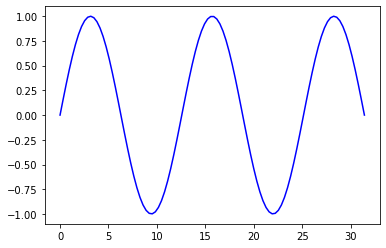

In [58]:
import matplotlib.pyplot as plt
import numpy as np
  
x = np.linspace(0, 10*np.pi, 100)
y = np.sin(x)
  
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
line1, = ax.plot(x, y, 'b-')
  
for phase in np.linspace(0, 10*np.pi, 100):
    line1.set_ydata(np.sin(0.5 * x + phase))
    fig.canvas.draw()
    fig.canvas.flush_events()

In [19]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

In [20]:
trainee = pd.read_csv(os.path.join(root_detection_gt, 'train_filenames.txt'), names=['filename'])
testee = pd.read_csv(os.path.join(root_detection_gt, 'test_filenames.txt'), names=['filename'])
print(f"Общее количество классов: {len(class_dict)}")
print(f"В обучающей выборке {len(os.listdir('C:/Users/yuras/Projects/Signs/data/detection/rtsd-d3-frames/train'))} фото ({len(trainee)})")
print(f"В тестовой выборке {len(os.listdir('C:/Users/yuras/Projects/Signs/data/detection/rtsd-d3-frames/test'))} фото ({len(testee)})")

Общее количество классов: 198
В обучающей выборке 9065 фото (9065)
В тестовой выборке 3022 фото (3022)


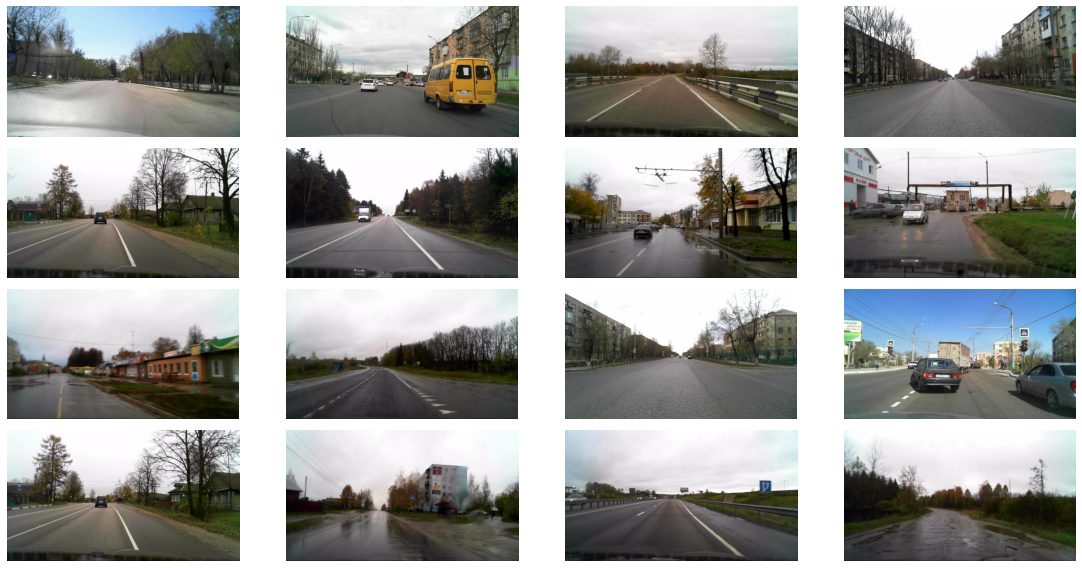

In [21]:
fig, axs = plt.subplots(4, 4, figsize=(16,8))

sample_gt = pd.read_csv(root_detection_gt + '/train_filenames.txt', names=['filename'], header=None)

for j in range(4):
    for i, name in zip(range(4), sample_gt.sample(4)['filename']):
        axs[j, i].imshow(plt.imread(f"C:/Users/yuras/Projects/Signs/data/detection/rtsd-d3-frames/train/{name}"))
        axs[j, i].axis('off')

fig.tight_layout()

# 6-Classes NET:
# blue_border, blue_rect, danger, main_roan, mandatory, prohibitory

## Transforms

In [22]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [23]:
train_dataset = RTSD_by_groups(root_image=root_detection_image, root_gt=root_detection_gt, train=True, transform=False)
test_dataset = RTSD_by_groups(root_image=root_detection_image, root_gt=root_detection_gt, train=False, transform=False)

In [24]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=2, shuffle=False)

In [23]:
model = models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

In [25]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

In [26]:
def do_training(model, data_loader, data_loader_test, num_epochs=4):
    # train on the GPU or on the CPU, if a GPU is not available
#     device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    device = torch.device('cpu')
    print("Using device %s" % device)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

In [26]:
do_training(model=model, data_loader=train_loader, data_loader_test=test_loader)

Using device cpu
Epoch: [0]  [   0/4533]  eta: 1 day, 5:12:00  lr: 0.000010  loss: 0.6791 (0.6791)  loss_classifier: 0.5556 (0.5556)  loss_box_reg: 0.0419 (0.0419)  loss_objectness: 0.0749 (0.0749)  loss_rpn_box_reg: 0.0067 (0.0067)  time: 23.1899  data: 0.4917  max mem: 0
Epoch: [0]  [  10/4533]  eta: 1 day, 5:47:18  lr: 0.000060  loss: 0.5527 (0.5202)  loss_classifier: 0.2797 (0.3360)  loss_box_reg: 0.0169 (0.0164)  loss_objectness: 0.0895 (0.1520)  loss_rpn_box_reg: 0.0075 (0.0157)  time: 23.7097  data: 0.1675  max mem: 0
Epoch: [0]  [  20/4533]  eta: 1 day, 6:29:12  lr: 0.000110  loss: 0.5200 (0.5043)  loss_classifier: 0.2916 (0.3381)  loss_box_reg: 0.0179 (0.0278)  loss_objectness: 0.0532 (0.1188)  loss_rpn_box_reg: 0.0100 (0.0195)  time: 24.3756  data: 0.1440  max mem: 0
Epoch: [0]  [  30/4533]  eta: 1 day, 7:17:43  lr: 0.000160  loss: 0.3684 (0.4588)  loss_classifier: 0.2723 (0.3130)  loss_box_reg: 0.0212 (0.0271)  loss_objectness: 0.0506 (0.1023)  loss_rpn_box_reg: 0.0076 (0.01

Epoch: [0]  [ 320/4533]  eta: 1 day, 7:26:17  lr: 0.001608  loss: 0.1323 (0.2084)  loss_classifier: 0.0529 (0.1232)  loss_box_reg: 0.0560 (0.0481)  loss_objectness: 0.0142 (0.0278)  loss_rpn_box_reg: 0.0047 (0.0094)  time: 24.0926  data: 0.1290  max mem: 0
Epoch: [0]  [ 330/4533]  eta: 1 day, 7:16:25  lr: 0.001658  loss: 0.1399 (0.2072)  loss_classifier: 0.0529 (0.1210)  loss_box_reg: 0.0466 (0.0477)  loss_objectness: 0.0173 (0.0289)  loss_rpn_box_reg: 0.0083 (0.0096)  time: 24.2435  data: 0.1333  max mem: 0
Epoch: [0]  [ 340/4533]  eta: 1 day, 7:06:35  lr: 0.001708  loss: 0.0916 (0.2044)  loss_classifier: 0.0270 (0.1186)  loss_box_reg: 0.0322 (0.0474)  loss_objectness: 0.0209 (0.0288)  loss_rpn_box_reg: 0.0058 (0.0096)  time: 24.2433  data: 0.1435  max mem: 0
Epoch: [0]  [ 350/4533]  eta: 1 day, 6:57:08  lr: 0.001758  loss: 0.0916 (0.2017)  loss_classifier: 0.0270 (0.1163)  loss_box_reg: 0.0381 (0.0478)  loss_objectness: 0.0128 (0.0282)  loss_rpn_box_reg: 0.0037 (0.0094)  time: 24.179

Epoch: [0]  [ 640/4533]  eta: 1 day, 3:27:47  lr: 0.003207  loss: 0.0923 (0.1634)  loss_classifier: 0.0277 (0.0844)  loss_box_reg: 0.0437 (0.0498)  loss_objectness: 0.0045 (0.0203)  loss_rpn_box_reg: 0.0032 (0.0089)  time: 23.8579  data: 0.1347  max mem: 0
Epoch: [0]  [ 650/4533]  eta: 1 day, 3:21:59  lr: 0.003257  loss: 0.0975 (0.1625)  loss_classifier: 0.0309 (0.0836)  loss_box_reg: 0.0459 (0.0498)  loss_objectness: 0.0023 (0.0202)  loss_rpn_box_reg: 0.0033 (0.0089)  time: 23.7643  data: 0.1378  max mem: 0
Epoch: [0]  [ 660/4533]  eta: 1 day, 3:16:20  lr: 0.003307  loss: 0.0975 (0.1618)  loss_classifier: 0.0318 (0.0830)  loss_box_reg: 0.0465 (0.0498)  loss_objectness: 0.0060 (0.0201)  loss_rpn_box_reg: 0.0073 (0.0089)  time: 23.8639  data: 0.1361  max mem: 0
Epoch: [0]  [ 670/4533]  eta: 1 day, 3:10:42  lr: 0.003357  loss: 0.0701 (0.1607)  loss_classifier: 0.0230 (0.0822)  loss_box_reg: 0.0352 (0.0496)  loss_objectness: 0.0060 (0.0200)  loss_rpn_box_reg: 0.0016 (0.0089)  time: 23.904

Epoch: [0]  [ 960/4533]  eta: 1 day, 0:40:34  lr: 0.004805  loss: 0.0770 (0.1469)  loss_classifier: 0.0273 (0.0699)  loss_box_reg: 0.0421 (0.0518)  loss_objectness: 0.0038 (0.0161)  loss_rpn_box_reg: 0.0038 (0.0091)  time: 23.6221  data: 0.1313  max mem: 0
Epoch: [0]  [ 970/4533]  eta: 1 day, 0:35:46  lr: 0.004855  loss: 0.0882 (0.1465)  loss_classifier: 0.0371 (0.0696)  loss_box_reg: 0.0435 (0.0519)  loss_objectness: 0.0038 (0.0160)  loss_rpn_box_reg: 0.0049 (0.0091)  time: 23.7547  data: 0.1327  max mem: 0
Epoch: [0]  [ 980/4533]  eta: 1 day, 0:30:52  lr: 0.004905  loss: 0.0846 (0.1458)  loss_classifier: 0.0371 (0.0692)  loss_box_reg: 0.0377 (0.0517)  loss_objectness: 0.0028 (0.0159)  loss_rpn_box_reg: 0.0046 (0.0090)  time: 23.6985  data: 0.1364  max mem: 0
Epoch: [0]  [ 990/4533]  eta: 1 day, 0:26:08  lr: 0.004955  loss: 0.0621 (0.1452)  loss_classifier: 0.0180 (0.0688)  loss_box_reg: 0.0335 (0.0516)  loss_objectness: 0.0030 (0.0158)  loss_rpn_box_reg: 0.0027 (0.0090)  time: 23.710

Epoch: [0]  [1290/4533]  eta: 22:05:56  lr: 0.005000  loss: 0.1149 (0.1377)  loss_classifier: 0.0352 (0.0619)  loss_box_reg: 0.0567 (0.0527)  loss_objectness: 0.0036 (0.0142)  loss_rpn_box_reg: 0.0038 (0.0089)  time: 23.2514  data: 0.1435  max mem: 0
Epoch: [0]  [1300/4533]  eta: 22:01:22  lr: 0.005000  loss: 0.1082 (0.1374)  loss_classifier: 0.0362 (0.0616)  loss_box_reg: 0.0629 (0.0527)  loss_objectness: 0.0026 (0.0141)  loss_rpn_box_reg: 0.0049 (0.0089)  time: 23.3132  data: 0.1421  max mem: 0
Epoch: [0]  [1310/4533]  eta: 21:56:47  lr: 0.005000  loss: 0.0717 (0.1369)  loss_classifier: 0.0219 (0.0614)  loss_box_reg: 0.0380 (0.0526)  loss_objectness: 0.0010 (0.0140)  loss_rpn_box_reg: 0.0019 (0.0089)  time: 23.3490  data: 0.1317  max mem: 0
Epoch: [0]  [1320/4533]  eta: 21:52:11  lr: 0.005000  loss: 0.0734 (0.1366)  loss_classifier: 0.0245 (0.0612)  loss_box_reg: 0.0347 (0.0526)  loss_objectness: 0.0010 (0.0140)  loss_rpn_box_reg: 0.0023 (0.0089)  time: 23.2794  data: 0.1317  max mem

Epoch: [0]  [1620/4533]  eta: 19:40:15  lr: 0.005000  loss: 0.1008 (0.1311)  loss_classifier: 0.0363 (0.0564)  loss_box_reg: 0.0496 (0.0531)  loss_objectness: 0.0046 (0.0127)  loss_rpn_box_reg: 0.0046 (0.0089)  time: 23.4129  data: 0.1324  max mem: 0
Epoch: [0]  [1630/4533]  eta: 19:35:52  lr: 0.005000  loss: 0.1008 (0.1310)  loss_classifier: 0.0322 (0.0563)  loss_box_reg: 0.0482 (0.0531)  loss_objectness: 0.0034 (0.0127)  loss_rpn_box_reg: 0.0037 (0.0089)  time: 23.2995  data: 0.1363  max mem: 0
Epoch: [0]  [1640/4533]  eta: 19:31:30  lr: 0.005000  loss: 0.0933 (0.1310)  loss_classifier: 0.0277 (0.0562)  loss_box_reg: 0.0462 (0.0532)  loss_objectness: 0.0015 (0.0126)  loss_rpn_box_reg: 0.0051 (0.0089)  time: 23.2158  data: 0.1423  max mem: 0
Epoch: [0]  [1650/4533]  eta: 19:27:05  lr: 0.005000  loss: 0.0933 (0.1310)  loss_classifier: 0.0277 (0.0561)  loss_box_reg: 0.0475 (0.0534)  loss_objectness: 0.0018 (0.0126)  loss_rpn_box_reg: 0.0054 (0.0090)  time: 23.1183  data: 0.1316  max mem

Epoch: [0]  [1950/4533]  eta: 17:21:02  lr: 0.005000  loss: 0.0760 (0.1271)  loss_classifier: 0.0234 (0.0529)  loss_box_reg: 0.0427 (0.0533)  loss_objectness: 0.0017 (0.0120)  loss_rpn_box_reg: 0.0019 (0.0089)  time: 23.4657  data: 0.1253  max mem: 0
Epoch: [0]  [1960/4533]  eta: 17:16:54  lr: 0.005000  loss: 0.0857 (0.1270)  loss_classifier: 0.0231 (0.0529)  loss_box_reg: 0.0449 (0.0533)  loss_objectness: 0.0029 (0.0119)  loss_rpn_box_reg: 0.0056 (0.0089)  time: 23.5920  data: 0.1387  max mem: 0
Epoch: [0]  [1970/4533]  eta: 17:12:46  lr: 0.005000  loss: 0.0909 (0.1269)  loss_classifier: 0.0286 (0.0528)  loss_box_reg: 0.0542 (0.0533)  loss_objectness: 0.0017 (0.0119)  loss_rpn_box_reg: 0.0058 (0.0089)  time: 23.7083  data: 0.1404  max mem: 0
Epoch: [0]  [1980/4533]  eta: 17:08:39  lr: 0.005000  loss: 0.0785 (0.1266)  loss_classifier: 0.0214 (0.0526)  loss_box_reg: 0.0401 (0.0532)  loss_objectness: 0.0017 (0.0118)  loss_rpn_box_reg: 0.0021 (0.0089)  time: 23.7464  data: 0.1348  max mem

Epoch: [0]  [2280/4533]  eta: 15:04:04  lr: 0.005000  loss: 0.0877 (0.1243)  loss_classifier: 0.0244 (0.0501)  loss_box_reg: 0.0458 (0.0535)  loss_objectness: 0.0037 (0.0117)  loss_rpn_box_reg: 0.0041 (0.0089)  time: 23.2707  data: 0.1317  max mem: 0
Epoch: [0]  [2290/4533]  eta: 14:59:54  lr: 0.005000  loss: 0.0877 (0.1241)  loss_classifier: 0.0226 (0.0500)  loss_box_reg: 0.0458 (0.0535)  loss_objectness: 0.0049 (0.0117)  loss_rpn_box_reg: 0.0050 (0.0089)  time: 23.0799  data: 0.1342  max mem: 0
Epoch: [0]  [2300/4533]  eta: 14:55:47  lr: 0.005000  loss: 0.0670 (0.1240)  loss_classifier: 0.0180 (0.0499)  loss_box_reg: 0.0341 (0.0535)  loss_objectness: 0.0035 (0.0116)  loss_rpn_box_reg: 0.0051 (0.0089)  time: 23.2878  data: 0.1436  max mem: 0
Epoch: [0]  [2310/4533]  eta: 14:51:59  lr: 0.005000  loss: 0.0733 (0.1239)  loss_classifier: 0.0215 (0.0498)  loss_box_reg: 0.0410 (0.0535)  loss_objectness: 0.0037 (0.0116)  loss_rpn_box_reg: 0.0035 (0.0089)  time: 24.3958  data: 0.1471  max mem

Epoch: [0]  [2610/4533]  eta: 13:14:51  lr: 0.005000  loss: 0.0546 (0.1196)  loss_classifier: 0.0179 (0.0474)  loss_box_reg: 0.0363 (0.0527)  loss_objectness: 0.0016 (0.0109)  loss_rpn_box_reg: 0.0023 (0.0086)  time: 27.2507  data: 0.1510  max mem: 0
Epoch: [0]  [2620/4533]  eta: 13:11:05  lr: 0.005000  loss: 0.0823 (0.1195)  loss_classifier: 0.0179 (0.0473)  loss_box_reg: 0.0458 (0.0527)  loss_objectness: 0.0020 (0.0109)  loss_rpn_box_reg: 0.0031 (0.0086)  time: 27.5620  data: 0.1614  max mem: 0
Epoch: [0]  [2630/4533]  eta: 13:07:19  lr: 0.005000  loss: 0.1105 (0.1195)  loss_classifier: 0.0278 (0.0473)  loss_box_reg: 0.0608 (0.0527)  loss_objectness: 0.0047 (0.0108)  loss_rpn_box_reg: 0.0045 (0.0087)  time: 27.8550  data: 0.1680  max mem: 0
Epoch: [0]  [2640/4533]  eta: 13:03:33  lr: 0.005000  loss: 0.1017 (0.1194)  loss_classifier: 0.0365 (0.0473)  loss_box_reg: 0.0481 (0.0527)  loss_objectness: 0.0010 (0.0108)  loss_rpn_box_reg: 0.0034 (0.0086)  time: 27.8902  data: 0.1622  max mem

Epoch: [0]  [2940/4533]  eta: 11:08:49  lr: 0.005000  loss: 0.0621 (0.1162)  loss_classifier: 0.0209 (0.0454)  loss_box_reg: 0.0245 (0.0523)  loss_objectness: 0.0036 (0.0102)  loss_rpn_box_reg: 0.0043 (0.0084)  time: 28.6694  data: 0.1675  max mem: 0
Epoch: [0]  [2950/4533]  eta: 11:04:46  lr: 0.005000  loss: 0.1004 (0.1162)  loss_classifier: 0.0191 (0.0453)  loss_box_reg: 0.0545 (0.0523)  loss_objectness: 0.0036 (0.0102)  loss_rpn_box_reg: 0.0071 (0.0084)  time: 27.2568  data: 0.1695  max mem: 0
Epoch: [0]  [2960/4533]  eta: 11:00:44  lr: 0.005000  loss: 0.0792 (0.1161)  loss_classifier: 0.0191 (0.0453)  loss_box_reg: 0.0502 (0.0522)  loss_objectness: 0.0022 (0.0102)  loss_rpn_box_reg: 0.0032 (0.0083)  time: 26.9171  data: 0.1581  max mem: 0
Epoch: [0]  [2970/4533]  eta: 10:56:43  lr: 0.005000  loss: 0.0665 (0.1160)  loss_classifier: 0.0162 (0.0452)  loss_box_reg: 0.0346 (0.0522)  loss_objectness: 0.0012 (0.0102)  loss_rpn_box_reg: 0.0032 (0.0084)  time: 27.1635  data: 0.1546  max mem

Epoch: [0]  [3270/4533]  eta: 9:01:14  lr: 0.005000  loss: 0.0688 (0.1141)  loss_classifier: 0.0223 (0.0439)  loss_box_reg: 0.0343 (0.0523)  loss_objectness: 0.0011 (0.0097)  loss_rpn_box_reg: 0.0035 (0.0082)  time: 40.1301  data: 0.2349  max mem: 0
Epoch: [0]  [3280/4533]  eta: 8:57:20  lr: 0.005000  loss: 0.0842 (0.1141)  loss_classifier: 0.0295 (0.0439)  loss_box_reg: 0.0423 (0.0523)  loss_objectness: 0.0016 (0.0097)  loss_rpn_box_reg: 0.0031 (0.0082)  time: 39.9869  data: 0.2421  max mem: 0
Epoch: [0]  [3290/4533]  eta: 8:53:05  lr: 0.005000  loss: 0.1062 (0.1140)  loss_classifier: 0.0297 (0.0438)  loss_box_reg: 0.0516 (0.0523)  loss_objectness: 0.0016 (0.0097)  loss_rpn_box_reg: 0.0031 (0.0082)  time: 29.0544  data: 0.1833  max mem: 0
Epoch: [0]  [3300/4533]  eta: 8:48:51  lr: 0.005000  loss: 0.0455 (0.1138)  loss_classifier: 0.0240 (0.0438)  loss_box_reg: 0.0217 (0.0522)  loss_objectness: 0.0011 (0.0097)  loss_rpn_box_reg: 0.0032 (0.0082)  time: 26.5966  data: 0.1600  max mem: 0


Epoch: [0]  [3600/4533]  eta: 6:40:10  lr: 0.005000  loss: 0.0581 (0.1113)  loss_classifier: 0.0248 (0.0423)  loss_box_reg: 0.0345 (0.0516)  loss_objectness: 0.0015 (0.0094)  loss_rpn_box_reg: 0.0040 (0.0081)  time: 23.3308  data: 0.1300  max mem: 0
Epoch: [0]  [3610/4533]  eta: 6:35:47  lr: 0.005000  loss: 0.0828 (0.1113)  loss_classifier: 0.0215 (0.0422)  loss_box_reg: 0.0492 (0.0516)  loss_objectness: 0.0015 (0.0094)  loss_rpn_box_reg: 0.0030 (0.0081)  time: 23.2469  data: 0.1320  max mem: 0
Epoch: [0]  [3620/4533]  eta: 6:31:23  lr: 0.005000  loss: 0.0738 (0.1112)  loss_classifier: 0.0214 (0.0422)  loss_box_reg: 0.0492 (0.0516)  loss_objectness: 0.0007 (0.0094)  loss_rpn_box_reg: 0.0019 (0.0080)  time: 23.2520  data: 0.1339  max mem: 0
Epoch: [0]  [3630/4533]  eta: 6:27:00  lr: 0.005000  loss: 0.0761 (0.1111)  loss_classifier: 0.0247 (0.0422)  loss_box_reg: 0.0510 (0.0516)  loss_objectness: 0.0015 (0.0093)  loss_rpn_box_reg: 0.0026 (0.0080)  time: 23.2801  data: 0.1267  max mem: 0


Epoch: [0]  [3930/4533]  eta: 4:16:45  lr: 0.005000  loss: 0.0902 (0.1093)  loss_classifier: 0.0243 (0.0410)  loss_box_reg: 0.0621 (0.0513)  loss_objectness: 0.0009 (0.0090)  loss_rpn_box_reg: 0.0036 (0.0079)  time: 23.7186  data: 0.1385  max mem: 0
Epoch: [0]  [3940/4533]  eta: 4:12:27  lr: 0.005000  loss: 0.1062 (0.1092)  loss_classifier: 0.0239 (0.0410)  loss_box_reg: 0.0664 (0.0513)  loss_objectness: 0.0015 (0.0090)  loss_rpn_box_reg: 0.0057 (0.0079)  time: 23.6903  data: 0.1369  max mem: 0
Epoch: [0]  [3950/4533]  eta: 4:08:09  lr: 0.005000  loss: 0.0762 (0.1092)  loss_classifier: 0.0205 (0.0410)  loss_box_reg: 0.0477 (0.0513)  loss_objectness: 0.0016 (0.0090)  loss_rpn_box_reg: 0.0042 (0.0079)  time: 23.7197  data: 0.1323  max mem: 0
Epoch: [0]  [3960/4533]  eta: 4:03:51  lr: 0.005000  loss: 0.0762 (0.1092)  loss_classifier: 0.0220 (0.0410)  loss_box_reg: 0.0471 (0.0514)  loss_objectness: 0.0019 (0.0090)  loss_rpn_box_reg: 0.0021 (0.0079)  time: 23.7508  data: 0.1380  max mem: 0


Epoch: [0]  [4260/4533]  eta: 1:55:36  lr: 0.005000  loss: 0.0832 (0.1077)  loss_classifier: 0.0256 (0.0401)  loss_box_reg: 0.0524 (0.0511)  loss_objectness: 0.0019 (0.0086)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 23.6525  data: 0.1355  max mem: 0
Epoch: [0]  [4270/4533]  eta: 1:51:21  lr: 0.005000  loss: 0.0746 (0.1076)  loss_classifier: 0.0241 (0.0401)  loss_box_reg: 0.0321 (0.0511)  loss_objectness: 0.0008 (0.0086)  loss_rpn_box_reg: 0.0024 (0.0078)  time: 23.6726  data: 0.1331  max mem: 0
Epoch: [0]  [4280/4533]  eta: 1:47:06  lr: 0.005000  loss: 0.0788 (0.1076)  loss_classifier: 0.0218 (0.0401)  loss_box_reg: 0.0321 (0.0511)  loss_objectness: 0.0008 (0.0086)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 23.7705  data: 0.1308  max mem: 0
Epoch: [0]  [4290/4533]  eta: 1:42:51  lr: 0.005000  loss: 0.0788 (0.1075)  loss_classifier: 0.0218 (0.0400)  loss_box_reg: 0.0410 (0.0511)  loss_objectness: 0.0029 (0.0086)  loss_rpn_box_reg: 0.0039 (0.0078)  time: 23.7747  data: 0.1305  max mem: 0


NameError: name 'evaluate' is not defined

In [27]:
datata = full_gt

In [28]:
img = 'autosave01_02_2012_09_16_57.jpg' #autosave01_02_2012_09_16_57
img_path = root_detection_image + '/train/' + img
boxes = []
labels = []

if img in list(datata['filename']):
    num_objs = datata['filename'].value_counts()[img]
            
    box = []
                    
    for _, row in datata[datata['filename'] == img].items():
        box.append(list(row))
                    
    for i in range(num_objs):
        bbox = [box[1][i], box[2][i], box[3][i]+box[1][i], box[4][i]+box[2][i]]
        boxes.append(bbox)
if len(boxes) == 1:
    boxes = [boxes[0],]
boxes = torch.as_tensor(boxes, dtype=torch.float32)
labels = torch.tensor([4, 5])
img = Image.open(img_path).convert('RGB')
print(boxes)
print(labels)

tensor([[170., 421., 192., 442.]])
tensor([4, 5])


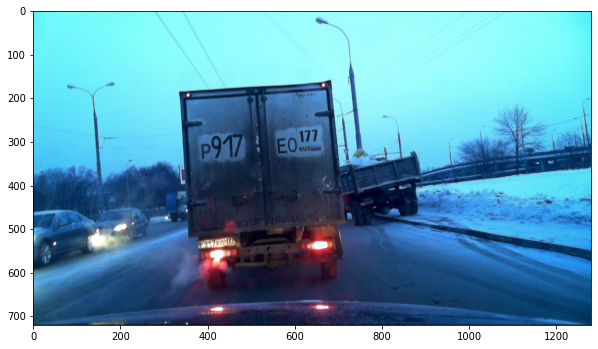

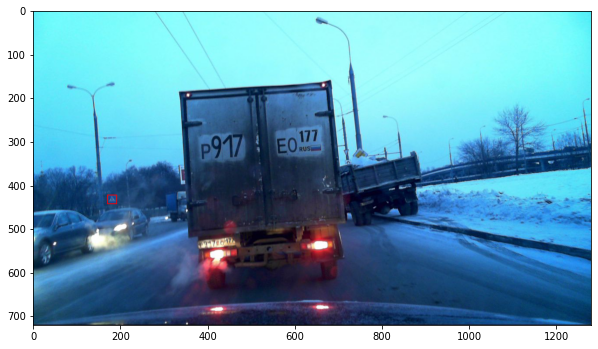

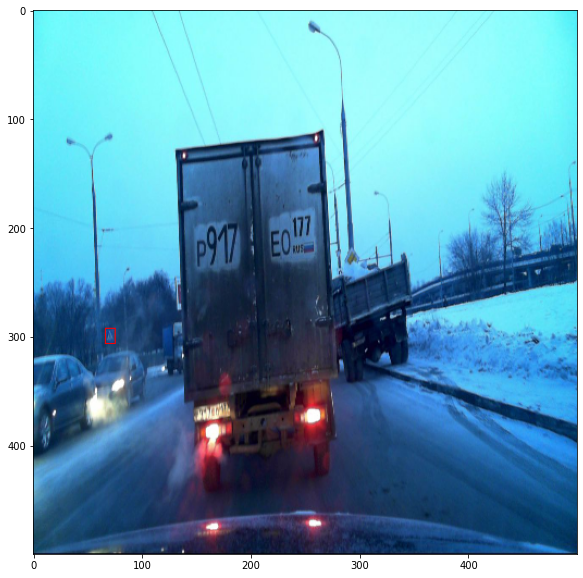

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
ax = plt.imshow(img)
show_img_with_bb(img, boxes, 2)
rs_img, rs_boxes = Resize_img_bb(img, boxes, (500, 500))
show_img_with_bb(rs_img, rs_boxes, 1)b

In [52]:
abab = torch.tensor([1.,2.,45.])
abab[1]

tensor(2.)

In [30]:
boxes

tensor([[170., 421., 192., 442.]])

In [ ]:
img_cv = cv2.imread(img_path)
cv2.imshow("original", img_cv)
for i, box in enumerate(boxes):
    cropped_img_cv = img_cv[box[1].to(torch.int32):box[3].to(torch.int32), box[0].to(torch.int32):box[2].to(torch.int32)]
    cv2.imshow("cropped"+str(i), cropped_img_cv)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [31]:
def crop(img, boxes):
    """Convert img to cv2-format, crop it and convert back to PIL-format"""
    
    cropped_imgs = []
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    for box in boxes:
        box = box.to(torch.int32)
        cropped_img = img[box[1]:box[3], box[0]:box[2]]
        cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        cropped_img = Image.fromarray(cropped_img)
        cropped_imgs.append(cropped_img)
        
    return cropped_imgs

In [ ]:
cropped_img = crop(img, boxes)
for i in cropped_img:
    plt.imshow(i)

## Вспомогательные функции

In [ ]:
def crossvalid(res_model=None,criterion=None,optimizer=None,dataset=None,k_fold=5):
    
    train_score = pd.Series()
    val_score = pd.Series()
    
    total_size = len(dataset)
    fraction = 1/k_fold
    seg = int(total_size * fraction)
    # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
    # index: [trll,trlr],[vall,valr],[trrl,trrr]
    for i in range(k_fold):
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size
        
        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))
        
        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))
        
        train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
        val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
        
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        train_acc = train(res_model,criterion,optimizer,train_loader,val_loader,1)
        train_score.at[i] = train_acc
        #val_acc = valid(res_model,criterion,optimizer,val_loader)
        #val_score.at[i] = val_acc
    
    return train_score,val_score

In [ ]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [ ]:
def train(res_model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = 0.

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()
            imgs = imgs.cuda()
            labels = labels.cuda()
            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))
            
            train_pred += (y_pred.argmax(1) == labels).sum()

            optimizer.step()

        train_acc_log.append(train_pred / train_size)

        val_loss = 0.
        val_size = 0
        
        val_pred = 0.
        
        model.eval()
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                imgs = imgs.cuda()
                labels = labels.cuda()
                
                pred = model(imgs)
                loss = criterion(pred, labels)
                
                val_loss += loss.item()
                val_size += pred.size(0)
                
                val_pred += (pred.argmax(1) == labels).sum()
        

        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_pred / val_size)

        clear_output()
        #plot_history(train_loss_log, val_loss_log, 'loss')
        


        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train acc:', (train_pred / train_size)*100)
        print('Val acc:', (val_pred / val_size)*100)
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [ ]:
def train_MyNet(model, train_loader, val_loader, criterion, optimizer, save_path, n_epochs=30):
    
    """ВОЗВРАЩАЕТ ОБУЧЕННУЮ МОДЕЛЬ"""
    val_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        since = time.time()
        train_loss_list = list()
        train_acc = list()
        val_loss_list = list()
        val_acc = list()
        
        #TRAIN DATASET
        
        model.train()
        for batch_idx, (images, labels) in enumerate(train_loader):
            #ПРЯМОЙ ПРОХОД
            outputs = model(images, labels)
            train_loss = criterion(outputs, labels)
            train_loss_list.append(train_loss.item())
            
            #ОБРАТНОЕ РАСПРОСТРАНЕНИЕ ОШИБКИ И ОПТИМИЗАЦИЯ
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            #КОНТРОЛЬ ТОЧНОСТИ МОДЕЛИ
            train_total = labels.size(0)
            _, train_predicted = torch.max(outputs.data, 1)
            train_correct = (train_predicted == labels).sum().item()
            train_acc.append(train_correct / train_total)
        
        #VALID DATASET
        
        model.eval()
        for batch_idx, (images, labels) in enumerate(val_loader):
            #ПРЯМОЙ ПРОХОД
            outputs = model(images, labels)
            val_loss = criterion(outputs, labels)
            val_loss_list.append(val_loss.item())
            
            #КОНТРОЛЬ ТОЧНОСТИ МОДЕЛИ
            val_total = labels.size(0)
            _, val_predicted = torch.max(outputs.data, 1)
            val_correct = (val_predicted == labels).sum().item()
            val_acc.append(val_correct / val_total)   
            
        time_elapsed = time.time() - since
        print(f'Epoch [{epoch}/{n_epochs}] complete in {(time_elapsed // (60 * 60)):.0f}h {((time_elapsed / 60) % 60):.0f}m. Train Loss: {train_loss.item():.4f}, Valid Loss: {val_loss.item():.4f}, Train Accuracy: {((train_correct / train_total) * 100):.2f}%, Valid Accuracy: {((val_correct / val_total) * 100):.2f}%')
    
        if val_loss <= val_loss_min:
            torch.save(model.state_dict(), save_path)
            val_loss_min = val_loss
            print('Validation Loss decreased! Model saved.')
            
    return model

## Модель

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Подргружаем модель

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 2)

# model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
train_MyNet(model=model, train_loader=train_loader_rt, val_loader=valid_loader_rt, criterion=criterion, optimizer=optimizer, save_path='RT_weights.pth', n_epochs=5)

## Посмотрим метрики нашей итоговой модели на валидации.

In [ ]:
model.eval()
valid_predicts = []

for imgs, _ in tqdm(valid_loader_rt):
    
#     imgs = imgs.cuda()
    pred = model(imgs)

    pred_numpy = pred.cpu().detach().numpy()

    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      valid_predicts.append(index)

In [ ]:
valid_df["pred"] = valid_predicts

# Посчитаем точность модели

In [ ]:
from sklearn.metrics import recall_score

In [ ]:
valid_df['pred'].values

In [ ]:
valid_df

In [ ]:
val_accuracy = recall_score(valid_df['red_triangles'].values, valid_df['pred'].values, average='macro', zero_division=0)
print(f"Validation accuracy = {val_accuracy}")